# Assignment 9: Multiple regression

### Learning Outcomes
This assignment introduces you to multiple regression analysis, model comparision between different multiple regression models and bootstrap for regression models. 
### Data set 
An investigator is interested in understanding the relationship, if any, between the analytical skills of young gifted children and the following variables: father’s IQ, mother’s IQ, age in month when the child first said ‘mummy’ or ‘daddy’, age in month when the child first counted to 10 successfully, average number of hours per week the child’s mother or father reads to the child, average number of hours per week the child watched an educational program on TV during the past three months, average number of hours per week the child watched cartoons on TV during the past three months. 

The analytical skills are evaluated using a standard testing procedure, and the score on this test is used as the response variable. Data were collected from schools in a large city on a set of thirty-six children who were identified as gifted children soon after they reached the age of four.
 
The data frame stored in gifted.csv contains the variables: 
- score:       Score in test of analytical skills.
- fatheriq:    Father’s IQ.
- motheriq:  Mother’s IQ.
- speak:       Age in months when the child first said ‘mummy’ or ‘daddy’.
- count:       Age in months when the child first counted to 10 successfully.
- read:         Average number of hours per week the child’s mother or father reads to the child.
- edutv:       Average number of hours per week the child watched an educational program on TV during the past three months.
- cartoons:  Average number of hours per week the child watched cartoons on TV during the past three months.

### Preliminaries
Set up the environment by importing pandas, numpy, and matplotlib, scipy.optimize. This is already done in the preliminaries. Ensure that you have fully mastered and understood HW7 before starting the assignment. 


In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.optimize as so
import pandas as pd 
import numpy as np
D = pd.read_csv('gifted.csv')

## Task 1: Implementing multiple regression ( / 28 pts)
### Question 1. ( / 6 pts)
Implement the function multRegPredict(b,D,xname). 
  - b is a list of parameter, with the first one being the intercept 
  - D is a DataFrame that contains the regressors
  - xname is a list of column names in D that will be added as regressors 

b needs to contain one more parameter (the intercept) than the numbers of regressors in xname. It will be helpful to start from the corresponding functions from last homework for polynomial regression. 

Then make a scatterplot of D.read and D.score 
Call your new function with yp = multRegPredict([134,11.8], D,['read']) and add predicted values to your plot (just call plt.scatter again – the dots will be added in a different color).  

Text(0, 0.5, 'Read')

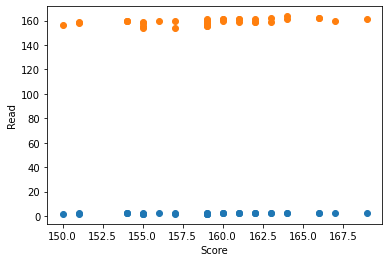

In [97]:
def multRegPredict(b,D,xname):
    yp = b[0] * np.ones(len(D))
    for i in range(len(xname)):
        yp = yp + b[i+1]*D[xname[i]] 
    return (yp)

plt.scatter(D.score,D.read)
yp = multRegPredict([134,11.8], D,['read'])
plt.scatter(D.score,yp)
plt.xlabel("Score")
plt.ylabel("Read")

### Question 2. ( / 10 pts)
Implement the function multRegLossRSS(b,D,y,xname). y is a list or np-array for the response variable. The function should get the predictions from multRegPredict, and then calculate the residual sum-of-squares, and the derivative of the loss function in respect to each parameter. Test the function by calling multRegLossRSS([134,11.8],D,D.score,['read']). Report the resulting RSS for the regression of score (response variable) against read (explanatory variable)- as well as the derivatives for each parameter. Written answer: From the value of the derivative, do you have to increase or decrease the slope parameter to get a better fit?

In [16]:
def multRegLossRSS(b,D,y,xname): 
    predY = multRegPredict(b,D,xname)
    res = y-predY
    rss = sum(res**2)
    deriv = np.zeros((len(xname) + 1))
    deriv[0] = -2*sum(res)
    for i in range(len(xname)):
        x_current = D[xname[i]]
        deriv[i+1] = -2*sum(x_current * res)
    return (rss,deriv)
    
rss,deriv = multRegLossRSS([134,11.8],D,D.score,['read'])
print("The RSS is",rss,"and the derivatives are",deriv)

The RSS is 543.5100000000003 and the derivatives are [ 4.84 10.3 ]


>I need to decrease the slope.

### Question 3 ( / 12 pts)
Implement the function multRegFit(D,y,xname), which uses so.minimize and multRegLossRSS to estimate the parameter values, and then calls multRegLossRSS again to calculate the R2 of the fit. The function should then return the R2 values and regression coefficients b. Use this print on the screen the R2-values for the models:

- y = b0  (hint, set xname = [])
- y = b0 + b1 \* read 
- y = b0 + b1 \* motheriq 
- y = b0 + b1 \* motheriq + b2 \* read

Which model has the highest R2? How do you interpret these results? How much of the variance of the response variable is uniquely explained by reading, how much by motheriq? Do the two variables explain each other away, explain independent parts of the variance, or show suppression? 

In [95]:
def multRegFit(D,y,xname,output=True):
    RESULT = so.minimize(multRegLossRSS, np.zeros(len(xname)+1), args = (D,y,xname), jac = True)
    TSS = sum((y - np.mean(y))**2)
    RSS,grad = multRegLossRSS(RESULT.x,D,y,xname)
    R2 = 1-(RSS/TSS)
    if output:
        print('R2 is',R2)
    return RESULT.x

print("y = b0")
multRegFit(D,D.score,[])
print("\ny = b0 + b1 * read")
multRegFit(D,D.score,['read'])
print("\ny = b0 + b1 * motheriq")
multRegFit(D,D.score,['motheriq'])
print("\ny = b0 + b1 * motheriq + b2 * read")
multRegFit(D,D.score,['motheriq','read'])

y = b0
R2 is 3.3306690738754696e-16

y = b0 + b1 * read
R2 is 0.2758322729769078

y = b0 + b1 * motheriq
R2 is 0.3263173772377883

y = b0 + b1 * motheriq + b2 * read
R2 is 0.6291342380411362


array([82.63542504,  0.42346452, 12.38890287])

> Highest model is y = b0 + b1 * motheriq + b2 * read. This means both read and motheriq are significant for score. 27.6% of the variance is explained by reading, and 32.6% by motheriq. Together they suppress the unwanted variability from eachother since the R2 of both in the model is higher than adding their individual R2's.

## Task 2: Do crossvalidation on these models  ( / 32 pts)
### Question 1 ( / 12 pts)
Modify the leaveOneOutCV function from last homework, so it works on a data frame with the multiple regression analysis. The inputs to the function are:  

def leaveOneOutCV(D,y,args=(),fitfcn=multRegFit,predictfcn=multRegPredict):
 - D: Data Frame with explanatory variables 
 - y: A list or np-array of the response variable
 - args: Input arguments for the fitfcn and predict function (xname) 
 - fitfcn: Function for fitting called as fitfcn(D,y,args)
 - predictfcn: Function for prediction called as predictfcn(D,y,args)


In [19]:
def leaveOneOutCV(D,y,args=(),fitfcn=multRegFit,predictfcn=multRegPredict):
    yp=np.zeros(len(D))
    for i in range(len(D)):
        df_train = D.iloc[D.index != i]
        df_test = D.iloc[D.index == i]
        ind = np.arange(len(y))
        ind = np.delete(ind,i)
        y_train = y[ind]
        b_train = fitfcn(df_train, y_train, args, output=False)
        yp[i]=predictfcn(b_train, df_test, args)
    TSS = sum((y - np.mean(y))**2)
    RSScv = sum((y-yp)**2)
    R2cv = 1-(RSScv/TSS)
    b = fitfcn(D, y, args, output=False)
    yf = predictfcn(b, D, args)
    RSS = sum((y-yf)**2)
    R2 = 1-(RSS/TSS)
    return R2,R2cv

### Question 2 ( / 8 pts)
Call the function to get the cross-validated R2 for the 4 models specified in Task 1, Question 3. How to you interpret these results? Is there evidence that reading increases the analytic score over and above what the IQ of the mother does? 

In [20]:
print("y = b0")
print(leaveOneOutCV(D,D.score)[1])
print("\ny = b0 + b1 * read")
print(leaveOneOutCV(D,D.score,args=['read'])[1])
print("\ny = b0 + b1 * motheriq")
print(leaveOneOutCV(D,D.score,args=['motheriq'])[1])
print("\ny = b0 + b1 * motheriq + b2 * read")
print(leaveOneOutCV(D,D.score,args=['motheriq','read'])[1])

y = b0
-0.05795918367345809

y = b0 + b1 * read
0.20419766461724764

y = b0 + b1 * motheriq
0.23646781973079922

y = b0 + b1 * motheriq + b2 * read
0.5760093385351055


### Question 3 ( / 4 pts)
Add the variable fatheriq to the model containing read and motheriq. Is there evidence that the IQ of the father improves the prediction over and above what hours reading and mother IQ can predict? 

In [21]:
print("y = b0 + b1 * motheriq + b2 * read + b3 * fatheriq")
print(leaveOneOutCV(D,D.score,args=['motheriq','read','fatheriq'])[1])

y = b0 + b1 * motheriq + b2 * read + b3 * fatheriq
0.6326907018776471


>Because the difference is less than 0.05, I don't think it is significant enough for evidence.

### Question 4 ( / 8 pts)
Is edutv (hours of educational TV) alone a reliable predictor of the analytic score? Does it add prediction power over and above from what the model motheriq + read + fatheriq can predict? 


In [22]:
print("y = b0 + b1 * edutv")
print(leaveOneOutCV(D,D.score,args=['edutv'])[1])
print("y = b0 + b1 * motheriq + b2 * read + b3 * fatheriq + b4 * edutv")
print(leaveOneOutCV(D,D.score,args=['motheriq','read','fatheriq','edutv'])[1])

y = b0 + b1 * edutv
0.037315563547506314
y = b0 + b1 * motheriq + b2 * read + b3 * fatheriq + b4 * edutv
0.6209659506666092


> It is neither a reliable predictor and it actually decreases the R2cv

## Task 3: Bootstrap for multiple regression. ( / 40 pts)
### Question 1 ( / 14 pts)
Implement bootstrap for linear regression. Start from the function bootstrap from Homework 3. The function should have input parameters
def bootstrapReg(D,y,args,fitfcn,numIter=500):
and should return a numIter x numParams np.array of bootstrap estimates.  
numParams is the length of b-vector returned from the fitfcn (in our case multiRegFit). That is, each column of the array should be the boostrap estimates for one of the regression coefficients. 

Note: you will also have to use here the following functions (add them to your notebook): 
- confidenceInt from HW 3 (Note that the posted version of HW3 had a bug in them).

Run the bootstrap on the data set in gifted.csv. Run the bootstrap on a simple regression model that explains ‘score’ from the explanatory variable ‘edutv’ alone. Report the CI for edutv -slope. Does the CI include zero- i.e. is the relationship between edutv and score significant? Which direction is the association between the two variables? 

In [101]:
def confidenceInt(data, prec):
    bounds = np.percentile(data, [(100-prec)/2,100-(100-prec)/2])
    return bounds

def bootstrapReg(D,y,args,fitfcn=multRegFit,numIter=500):
    numParams = len(args)+1
    b = fitfcn(D,y,args, output=False)
    N = len(D)
    ind = np.arange(len(D.index))
    stats = np.zeros([numIter,numParams])
    for i in range(numIter):
        sample = np.random.choice(ind, N, replace = True)
        sample_df = D.iloc[sample]
        sample_df.index = ind
        x = fitfcn(sample_df, y, args, output=False)
        stats[i,:] = x
    return stats

boot0 = bootstrapReg(D,D.score,['edutv'])
confInt = confidenceInt(boot[:,1],95)
print(confInt)

[-6.60700801  7.88882339]


> The confidence interval does include 0, so the relationshipp is not significant. The direction is positive.

### Question 2 ( / 8 pts)
Run the bootstrap on the model that explains score as a function of hours of cartoons watched. Is there a significant relationship between ‘cartoons’ and ‘score’? 

In [103]:
boot1 = bootstrapReg(D,D.score,['cartoons'])
confInt = confidenceInt(boot1[:,1],95)
print(confInt)

[-2.53130941  2.40405586]


> There is no significant relationship as the CI contains 0.

### Question 3 ( / 8 pts)
Run the bootstrap on a model that explains score as a function of edutv and cartoons. Report the CIs for both variabless. Do the conclusion from Question 1 and 2 change? Have the CIs become smaller or larger as compared to the simple regression models from Question 1 and 2?

In [104]:
boot2 = bootstrapReg(D,D.score,['edutv','cartoons'])
print('edutv:')
confInt = confidenceInt(boot2[:,1],95)
print(confInt)
print('\ncartoons:')
confInt = confidenceInt(boot2[:,2],95)
print(confInt)

edutv:
[-6.76832261  7.76105394]

cartoons:
[-6.32926112  6.71970487]


>The conclusion doesn't change, and the cartoons interval has widened.

### Question 4 ( / 10 pts)
Plot the bootstrap estimates for edutv and cartoons from Question 3 against each other in a scatter plot. Are they positively or negatively related? What does this mean for the relationship between the regressors?

Text(0.5, 0, 'edutv')

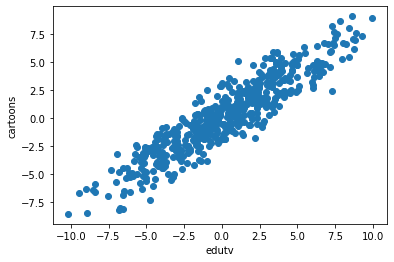

In [106]:
plt.scatter(boot2[:,1],boot2[:,2])
plt.ylabel('cartoons')
plt.xlabel('edutv')

>They are positively related. This means there is a negative relation on the slope between the two, and more variability in estimates.